In [1]:
import torch
import sam2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor as SAM
import cv2
import numpy as np
from PIL import  Image
import matplotlib.pyplot as plt
import scipy
import skimage

KeyboardInterrupt: 

In [ ]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
def valid_pts(pts, bbox):
    if isinstance(pts, list):
        pts = np.array(pts)
    if pts.shape[0] == 0:
        return pts
        
    pts -= bbox[:2][::-1]
    check = np.ones(pts.shape[0])
    for i in range(pts.shape[1]):
        check *= np.where((pts[:, i] > 0) & (pts[:, i] < bbox[i + 2]), 1, 0)
    return pts[np.where(check > 0)]

---

In [ ]:
image = cv2.imread("../data/v2/2015.png", cv2.IMREAD_UNCHANGED)
mask = image[:, :, 3]
image = image[:, :, :3]

In [ ]:
%set_env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


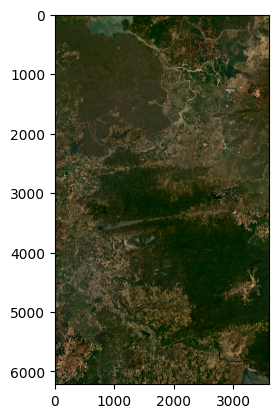

In [ ]:
plt.imshow(image[:, :, ::-1])

In [ ]:
y, x, h, w = 2400, 0, 1200, 1200

In [ ]:
patch = image[y:y+h, x:x+w]
ref = mask[y:y+h, x:x+w]

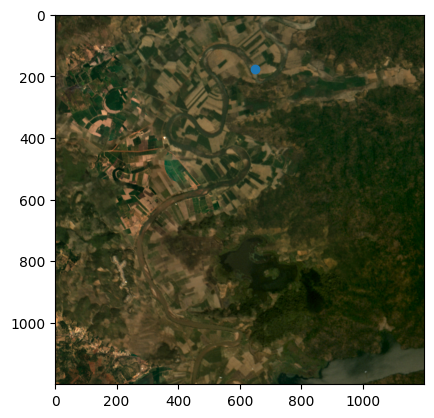

In [ ]:
plt.imshow(patch[:,:, ::-1])
plt.scatter([650], [175])

In [ ]:
def get_bbox(bound, pt, patch_size):
    x = min(bound[1] - patch_size[1], max(0, pt[1] - patch_size[1] // 2))
    y = min(bound[0] - patch_size[0], max(0, pt[0] - patch_size[0] // 2))
    return x, y, patch_size[0], patch_size[1]

In [ ]:
pts = np.array([175, 640])
bbox = get_bbox(patch.shape[:2], [175, 650], [512, 512])
new_pts = pts - bbox[:2][::-1]

In [ ]:
print(bbox, new_pts)

(394, 0, 512, 512) [175 246]


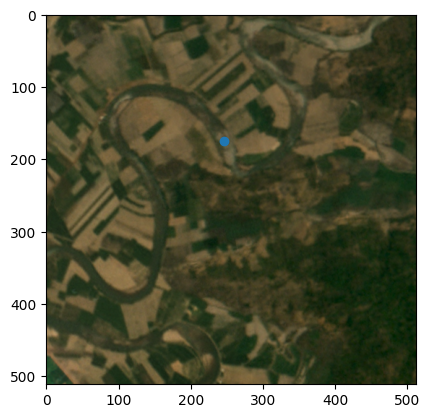

In [ ]:
cropped = patch[bbox[1]:bbox[1] + 512, bbox[0]:bbox[0] + 512]
plt.imshow(cropped[:,:, ::-1])
plt.scatter([new_pts[1]], [new_pts[0]])

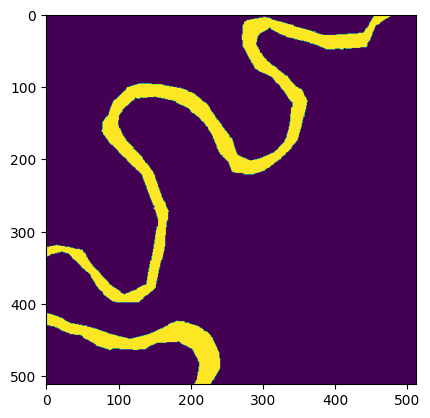

In [ ]:
patch_mask = ref[bbox[1]:bbox[1] + 512, bbox[0]:bbox[0] + 512]
plt.imshow(patch_mask)

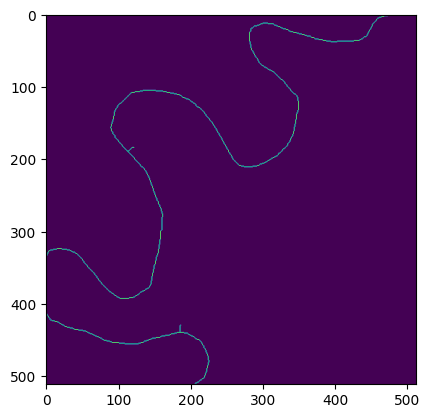

In [ ]:
ske = skimage.morphology.skeletonize(patch_mask)
plt.imshow(ske)

In [ ]:
checkpoint = "/work/hpc/potato/sam/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"
sam = build_sam2(model_cfg, checkpoint)
model = SAM(sam)

In [ ]:
type(model)

sam2.sam2_image_predictor.SAM2ImagePredictor

In [ ]:
patch.shape

(1200, 1200, 3)

In [ ]:
model.set_image(cropped)

In [ ]:
patch_size = [512, 512]

positives = []
negatives = []
mask = np.zeros_like(ref).astype(float)
weight = np.zeros_like(ref).astype(float)
outpus = np.zeros_like(ref).astype(float)


kernel = [cv2.getGaussianKernel(patch_size[0], -1), cv2.getGaussianKernel(patch_size[1], -1)]
kernel = (kernel[0] / kernel[0][0, 0]) * (kernel[1] / kernel[1][0, 0]).T
kernel /= kernel.sum() 

In [ ]:
import torch

In [ ]:
model.set_image(cropped)

In [ ]:
positives.append(pts)

In [ ]:
valid_pos = valid_pts(positives, bbox)
valid_neg = valid_pts(negatives, bbox)

In [ ]:
def compose_prompts(positive, negative):
    pos_label = np.ones(positive.shape[0])
    neg_label = np.zeros(negative.shape[0])
    if negative.shape[0] == 0:
        return positive[:, ::-1].copy(), pos_label
    pts = np.concatenate([positive, negative], axis=0)
    labels = np.concatenate((pos_label, neg_label))
    return pts[:, ::-1].copy(), labels

In [ ]:
infer_pts, labels = compose_prompts( valid_pos, valid_neg)

In [ ]:
predictor.model.to("cuda")

NameError: name 'predictor' is not defined

In [ ]:
masks, scores, logits = model.predict(point_coords=infer_pts, point_labels=labels, multimask_output=False)

In [ ]:
masks.shape

(1, 512, 512)

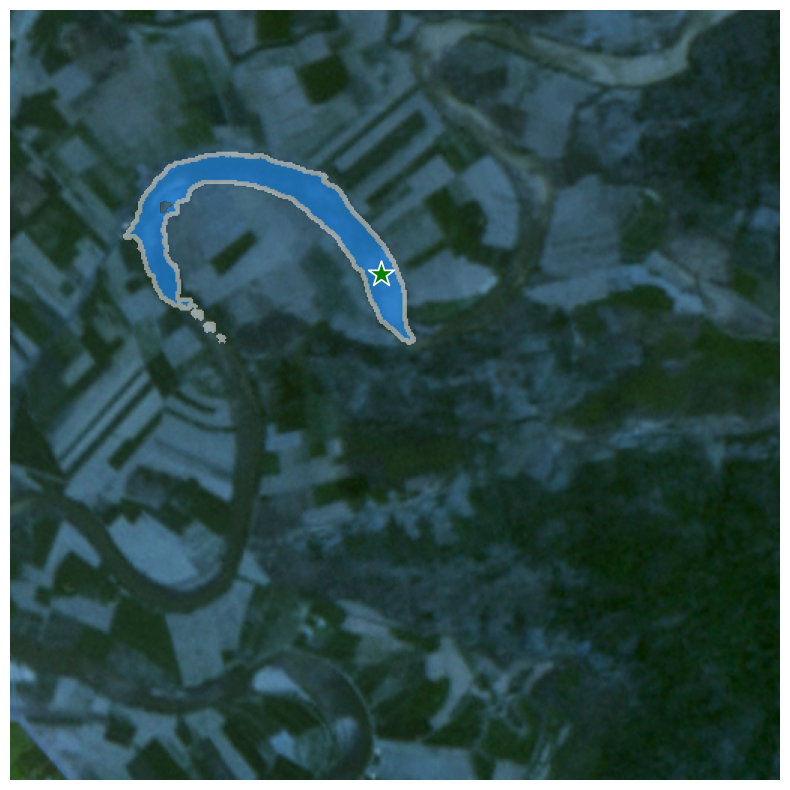

In [ ]:
show_masks(cropped, masks, scores, point_coords=infer_pts, input_labels=labels)

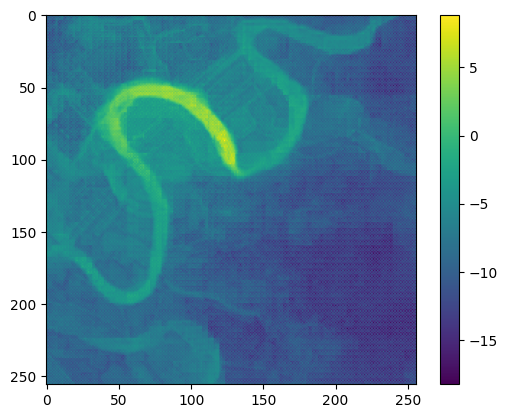

In [ ]:
plt.imshow(logits[0])
plt.colorbar()

In [ ]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

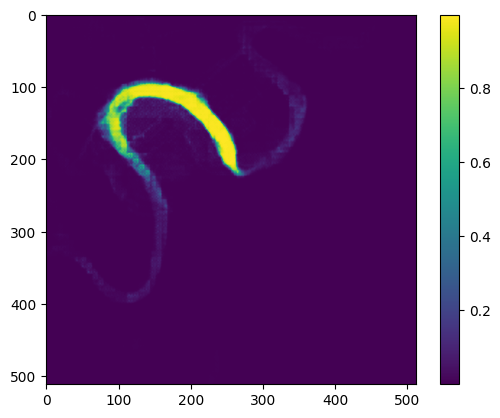

In [ ]:
logit_map = sigmoid(cv2.resize(logits.squeeze(), patch_size[::-1], cv2.INTER_LINEAR))
plt.imshow(logit_map)
plt.colorbar()

In [ ]:
out_mask = np.zeros_like(ref).astype(float)
out_weight = np.zeros_like(ref).astype(float)
out_logit = np.zeros_like(ref).astype(float)
pred_mask = np.zeros_like(ref)

In [ ]:
out_logit[bbox[1]:bbox[1] + patch_size[0], bbox[0]:bbox[0] + patch_size[1]] += kernel * logit_map
out_weight[bbox[1]:bbox[1] + patch_size[0], bbox[0]:bbox[0] + patch_size[1]] += kernel
out_mask = out_logit / (out_weight + 1e5)
pred_mask[bbox[1]:bbox[1] + patch_size[0], bbox[0]:bbox[0] + patch_size[1]] = pred_mask[bbox[1]:bbox[1] + patch_size[0], bbox[0]:bbox[0] + patch_size[1]] + masks.squeeze() - pred_mask[bbox[1]:bbox[1] + patch_size[0], bbox[0]:bbox[0] + patch_size[1]]*masks.squeeze()

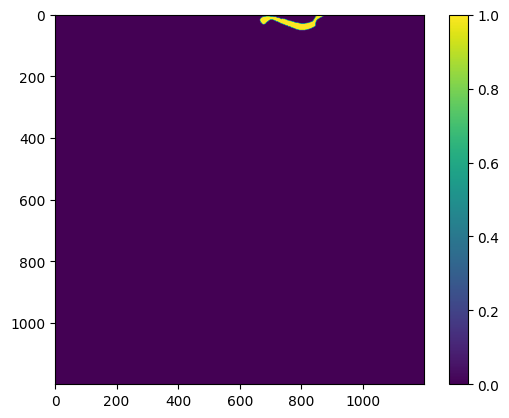

In [ ]:
plt.imshow(pred_mask)
plt.colorbar()

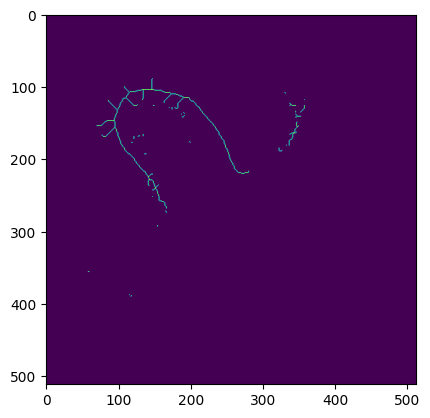

In [ ]:
mask = scipy.ndimage.binary_fill_holes(np.where(logit_map > 0.1, 1, 0)).astype(int).astype(np.uint8)
skeleton = skimage.morphology.skeletonize(mask)
plt.imshow(skeleton)

In [ ]:
ske_pts = np.array(np.where(skeleton > 0)).T
print(ske_pts.shape)
dist = np.linalg.norm(ske_pts - new_pts, axis=1)
nn = np.argmin(dist)

(669, 2)


In [ ]:
checkpoint = ske_pts[nn]

In [ ]:
from collections import defaultdict
def dfs_tree(mask, start):
    rows, cols = mask.shape[:2]
    stack = [start]
    visited = set()
    parent = {}
    directions = [(-1, 0),(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)] 
    dfs_tree = defaultdict(list)
    
    while stack:
        x, y = stack.pop()
        
        if (x, y) in visited:
            continue
        
        visited.add((x, y))
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and mask[nx, ny] == 1 and (nx, ny) not in visited:
                stack.append((nx, ny))
                parent[(nx, ny)] = (x, y)
                dfs_tree[(x, y)].append((nx, ny))
    
    return dfs_tree, parent

In [ ]:
tree, parent = dfs_tree(skeleton, checkpoint)

In [ ]:
def longest_path(tree, start):
    def dfs(node, path):
        path.append(node)
        max_path = path[:]
        
        for neighbor in tree[node]:
            new_path = dfs(neighbor, path[:])
            if len(new_path) > len(max_path):
                max_path = new_path
        
        return max_path
    
    return dfs(start, [])

In [ ]:
path = longest_path(tree, tuple(checkpoint.tolist()))

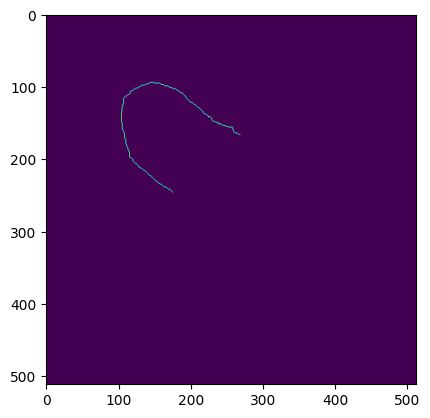

In [ ]:
contour = np.array(path)
empty = np.zeros_like(test)
cv2.polylines(empty, [contour], 0, 1)
plt.imshow(empty)

In [ ]:
xx = [x for y, x in path]
yy = [y for y, x in path]
trace_back = 20
trace_end = 0
tck, u = scipy.interpolate.splprep([yy[-trace_back:], xx[-trace_back:]], k=3, s=2)

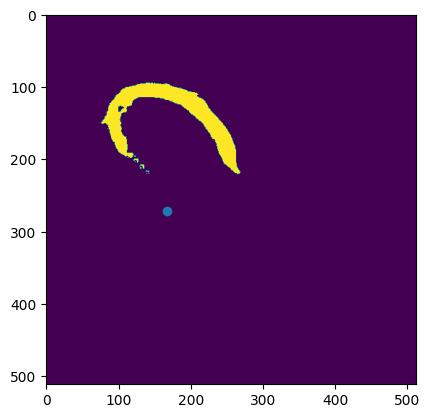

In [ ]:
arr = [1.2]
next_pt = np.round(np.array(scipy.interpolate.splev(arr, tck)).T).astype(int)
plt.imshow(masks.squeeze())
plt.scatter(next_pt[:, 1], next_pt[:, 0])

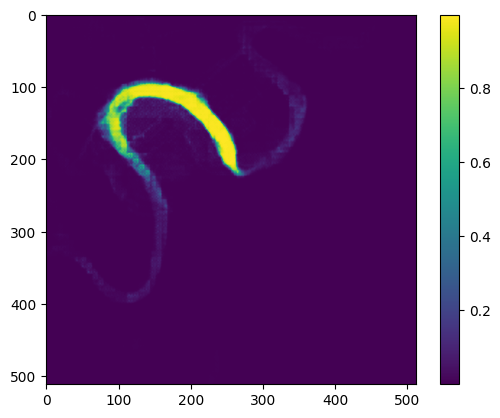

In [ ]:
plt.imshow(logit_map)
plt.colorbar()

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
dilated_mask = cv2.morphologyEx(cv2.dilate(masks.squeeze(), kernel, iterations=5), cv2.MORPH_GRADIENT, kernel)
possible = scipy.ndimage.binary_fill_holes(np.where(logit_map > 0.05, 1, 0)).astype(int).astype(np.uint8)
dilated_possible = cv2.dilate(possible, kernel, iterations=3)
negative_field = dilated_mask - dilated_mask * dilated_possible

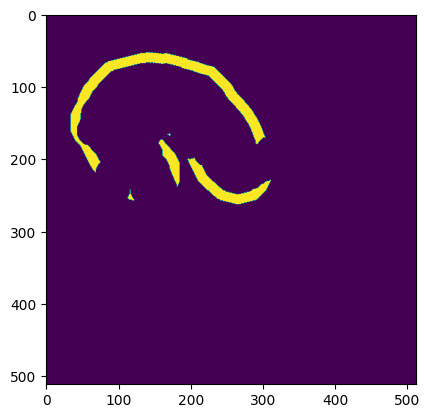

In [ ]:
plt.imshow(negative_field)

In [ ]:
from functools import  partial

In [ ]:
grid = np.linspace(0, 1, 5)[:-1]
mesh = np.stack(np.meshgrid(grid, grid), axis=-1).reshape(-1, 2) * [512, 512]
mesh = mesh.astype(int)
def grid_sampling(src, patch_size, mask):
    dst = src + patch_size
    if np.mean(mask[src[0]:dst[0],src[1]:dst[1]]) < 0.05:
        return [-1, -1]
    possible = np.array(np.where(mask[src[0]:dst[0],src[1]:dst[1]] > 0)).T
    return possible[np.random.randint(0, high=possible.shape[0])] + src
tgt = partial(grid_sampling, patch_size=[64, 64], mask=negative_field) 
output = np.apply_along_axis(tgt, 1, mesh)
output = output[output[:, 0] > 0]
print(output)

[[150  40]
 [ 58 142]
 [157 292]]


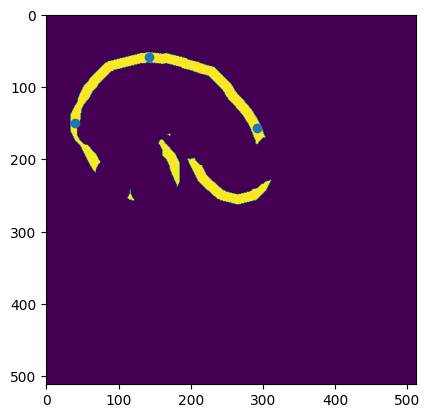

In [ ]:
plt.imshow(negative_field)
plt.scatter(output[:, 1], output[:, 0])

In [ ]:
neg_field_pts = np.array(np.where(negative_field > 0)).T
neg_idx = np.random.randint(0, neg_field_pts.shape[0], size=[5])
neg_pts = neg_field_pts[neg_idx]

/tmp/ipykernel_1202856/2293443445.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(neg_pts[:, 1], neg_pts[:, 0], c=(1, 0, 0))
/tmp/ipykernel_1202856/2293443445.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(next_pt[:, 1], next_pt[:, 0], c=(0, 0, 1))


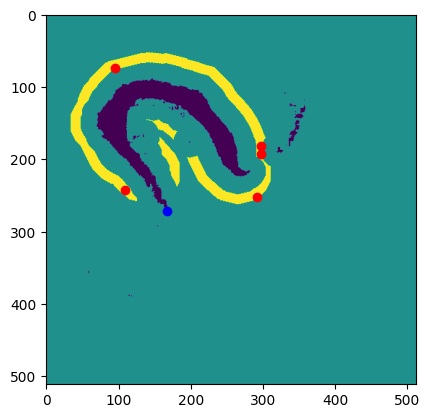

In [ ]:
plt.imshow(negative_field - possible)
plt.scatter(neg_pts[:, 1], neg_pts[:, 0], c=(1, 0, 0))
plt.scatter(next_pt[:, 1], next_pt[:, 0], c=(0, 0, 1))

In [ ]:
positives = [pts]
negatives = []
bbox = get_bbox(patch.shape[:2], pts, patch_size)
neg_pts = output

In [ ]:
positives += (next_pt + bbox[:2][::-1]).tolist()
negatives += (neg_pts + bbox[:2][::-1]).tolist() 

In [ ]:
pt = positives[-1]
bbox = get_bbox(patch.shape[:2], pt, patch_size)

In [ ]:
bbox

(295, 15, 512, 512)

In [ ]:
cropped = patch[bbox[1]:bbox[1] + patch_size[0], bbox[0]:bbox[0] + patch_size[1]]
model.set_image(cropped)

In [ ]:
valid_pos = valid_pts(positives, bbox)
valid_neg = valid_pts(negatives, bbox)
print(valid_pos, valid_neg)

[[160 345]
 [256 256]] [[135 129]
 [ 43 231]
 [142 381]]


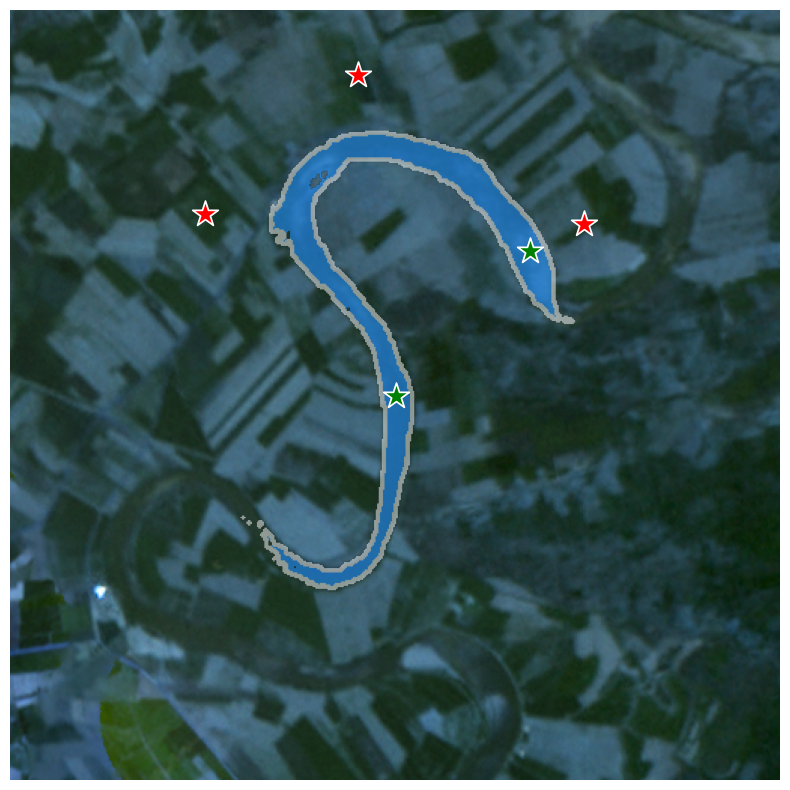

In [ ]:
prompts, labels = compose_prompts(valid_pos, valid_neg)
masks_1, scores_1, logits_1 = model.predict(point_coords=prompts, point_labels=labels, multimask_output=False)
show_masks(cropped, masks_1, scores_1, point_coords=prompts, input_labels=labels)

In [ ]:
scores_1

array([0.7710133], dtype=float32)

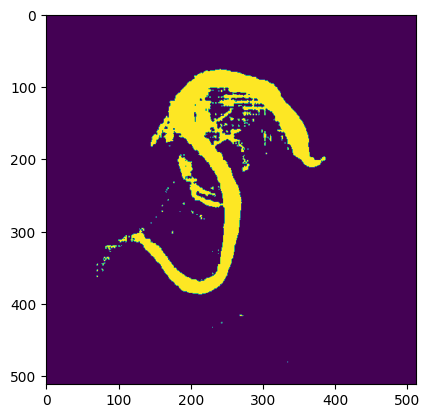

In [ ]:
plt.imshow(cv2.resize(sigmoid(logits_1.squeeze()), patch_size[::-1]) > 0.1)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
possible = (cv2.resize(sigmoid(logits_1.squeeze()), patch_size[::-1]) > 0.1).astype(int).astype(np.uint8)
closed_poss = cv2.morphologyEx(possible, cv2.MORPH_OPEN, kernel, iterations=1)

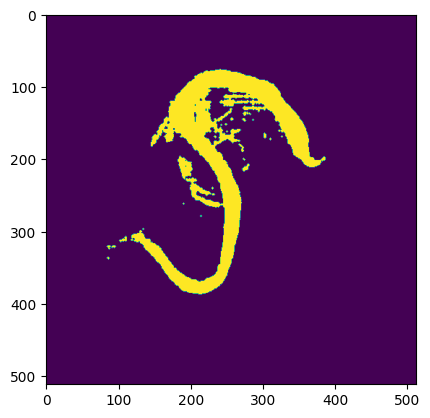

In [ ]:
plt.imshow(closed_poss)

In [ ]:
def thinning(mask, return_weight=False):
  #thinning word into a line
  # Structuring Element
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  weight = np.zeros(mask.shape, dtype=np.uint8)
  # early stopping
  if cv2.countNonZero(cv2.erode(mask,kernel)) == 0:
    return mask

  # Create an empty output image to hold values
  thin = np.zeros(mask.shape,dtype='uint8')
  # Loop until erosion leads to an empty set
  while cv2.countNonZero(mask)!= 0:
    # Erosion
    erode = cv2.erode(mask,kernel)
    # Opening on eroded image
    opened = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
    # Subtract these two
    subset = erode - opened
    # Union of all previous sets
    thin = cv2.bitwise_or(subset,thin)
    # Keep the cummulative for weighting
    weight += thin
    # Set the eroded image for next iteration
    mask = erode.copy()
  
  if not return_weight:
    return thin
  else:
    return thin, weight


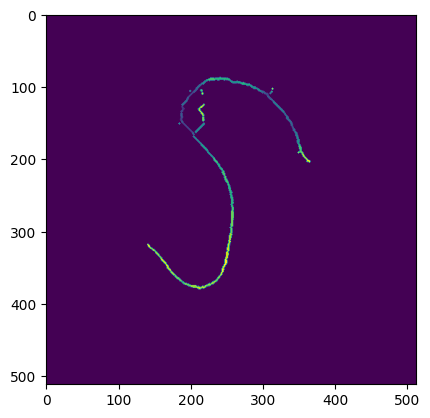

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
skeleton, ske_w = thinning(closed_poss, return_weight=True)
# cv2.imwrite('/work/hpc/potato/airc/data/viz/skeleton_weight.jpg', (np.repeat(ske_w[:, :, None], 3, axis=-1) / ske_w.max() * 255).astype(int).astype(np.uint8))
ske_w = cv2.morphologyEx(ske_w,cv2.MORPH_DILATE,kernel)
cv2.imwrite('/work/hpc/potato/airc/data/viz/skeleton_weight.jpg', (np.repeat(ske_w[:, :, None], 3, axis=-1).astype(float) / ske_w.max() * 255).astype(int).astype(np.uint8))
ske_w = ske_w.astype(float)
plt.imshow((ske_w < ske_w.max() * 0.75) * ske_w)

In [ ]:
skeleton = skimage.morphology.skeletonize((ske_w < ske_w.max() * 0.75) & (ske_w > 0))
ske_pts = np.array(np.where(skeleton > 0)).T
print(ske_pts.shape)
dist = np.linalg.norm(ske_pts - valid_pos[-1], axis=1)
nn = np.argmin(dist)

(610, 2)


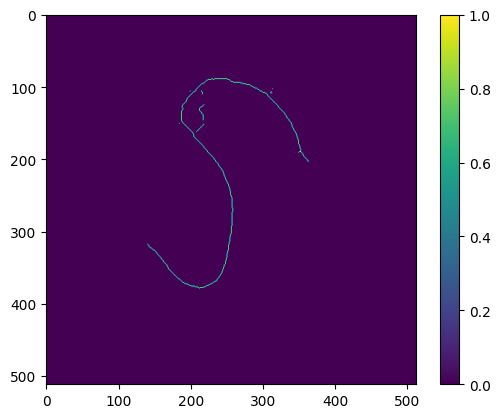

In [ ]:
plt.imshow(skeleton)
plt.colorbar()


(256, 257)


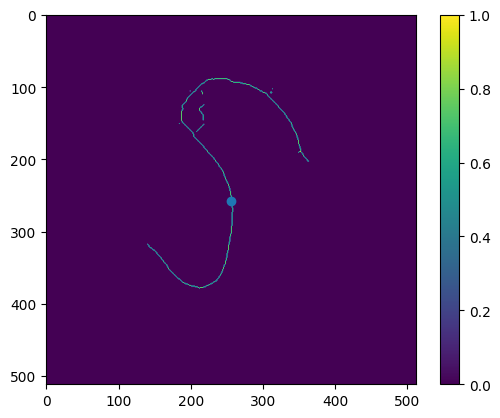

In [ ]:
start = tuple(ske_pts[nn].tolist())
print(start)
plt.imshow(skeleton)
plt.scatter(*start)
plt.colorbar()
tree, parent = dfs_tree(skeleton, start)
path = longest_path(tree, start)

In [ ]:
len(path)

346

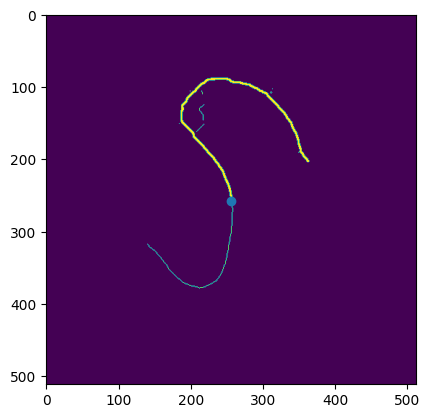

In [ ]:
empty = skeleton.copy().astype(int).astype(np.uint8)
cv2.polylines(empty, [np.array(path)[:, ::-1]], 0, 1, 2)
plt.scatter(*start)
plt.imshow(empty)

In [ ]:
xx = [x for y, x in path]
yy = [y for y, x in path]
trace_back = 20
trace_end = 0
tck, u = scipy.interpolate.splprep([yy[-trace_back:], xx[-trace_back:]], k=3, s=2)

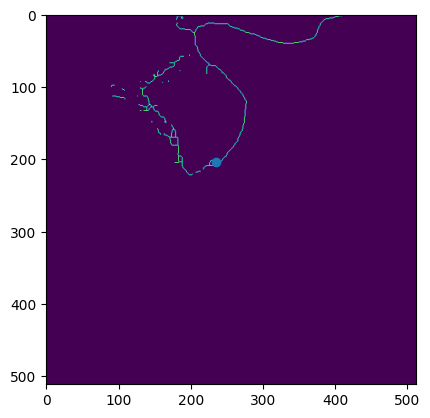

In [ ]:
arr = [1.]
next_pt = np.round(np.array(scipy.interpolate.splev(arr, tck)).T).astype(int)
plt.imshow(skeleton.squeeze())
plt.scatter(next_pt[:, 1], next_pt[:, 0])

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
dilated_mask = cv2.morphologyEx(cv2.dilate(masks_1.squeeze(), kernel, iterations=5), cv2.MORPH_GRADIENT, kernel)
# possible = scipy.ndimage.binary_fill_holes(np.where(logits_1.squeeze() > 0.1, 1, 0)).astype(int).astype(np.uint8)
dilated_possible = cv2.dilate(possible, kernel, iterations=3)
negative_field = dilated_mask - dilated_mask * dilated_possible

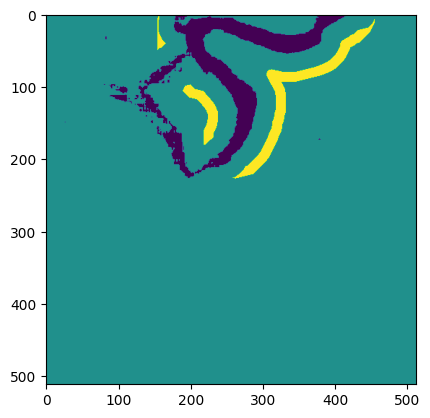

In [ ]:
plt.imshow(negative_field - possible)

/tmp/ipykernel_2025641/3465676623.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(neg_pts[:, 1], neg_pts[:, 0], c=(1, 0, 0))
/tmp/ipykernel_2025641/3465676623.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(next_pt[:, 1], next_pt[:, 0], c=(0, 0, 1))


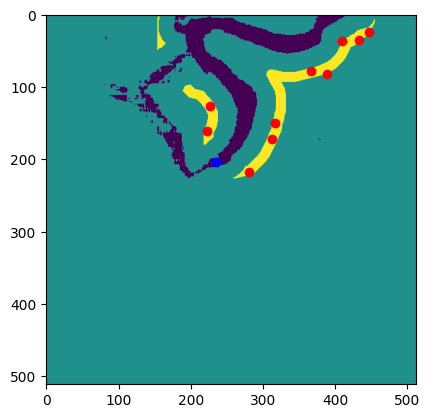

In [ ]:
neg_field_pts = np.array(np.where(negative_field > 0)).T
neg_idx = np.random.randint(0, neg_field_pts.shape[0], size=[10])
neg_pts = neg_field_pts[neg_idx]
plt.imshow(negative_field - possible)
plt.scatter(neg_pts[:, 1], neg_pts[:, 0], c=(1, 0, 0))
plt.scatter(next_pt[:, 1], next_pt[:, 0], c=(0, 0, 1))

In [ ]:
positives += (next_pt + bbox[:2][::-1]).tolist()
negatives += (neg_pts + bbox[:2][::-1]).tolist() 

In [ ]:
pt = positives[-1]
bbox = get_bbox(patch.shape[:2], pt, patch_size)
cropped = patch[bbox[1]:bbox[1] + patch_size[0], bbox[0]:bbox[0] + patch_size[1]]
predictor.set_image(cropped)

In [ ]:
valid_pos = valid_pts(positives, bbox)
valid_neg = valid_pts(negatives, bbox)
print(valid_pos, valid_neg)


[[ 39 355]
 [ 97 277]
 [204 256]] [[ 29 181]
 [ 71 316]
 [ 84 401]
 [ 23 454]
 [ 29 456]
 [218 301]
 [172 334]
 [ 24 468]
 [ 77 388]
 [ 35 454]
 [126 248]
 [ 36 431]
 [149 338]
 [161 243]
 [ 81 410]]


In [ ]:
prompts, labels = compose_prompts(valid_pos, valid_neg[5:])
masks_2, scores_2, logits_2 = predictor.predict(point_coords=prompts, point_labels=labels, multimask_output=False)

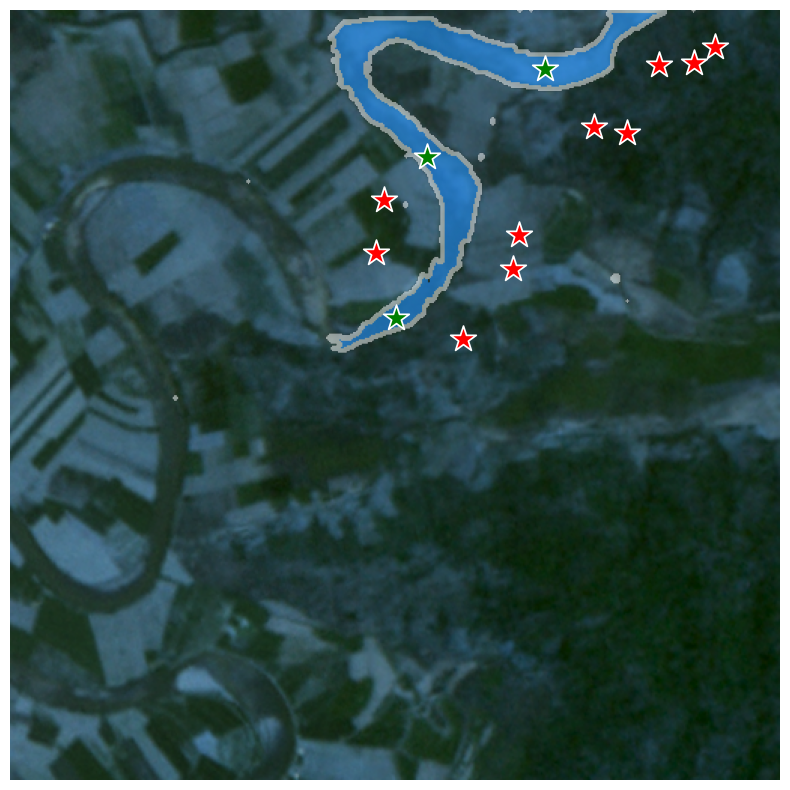

In [ ]:
logit_mask = cv2.resize(sigmoid(logits_2.squeeze()), patch_size[::-1], cv2.INTER_LINEAR) > 0.1
show_masks(cropped, logit_mask[None, :, :], scores_2, point_coords=prompts, input_labels=labels)

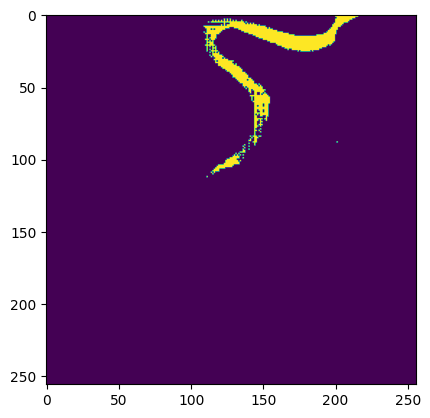

In [ ]:
plt.imshow(sigmoid(logits_2[0]) > 0.3)